Datasets used:
1. Shots Fired
2. Shootings - Datasets - Analyze Boston

Assumption made:

District 4 is made up of Boston Police Districts B2, B3, C11 and E5

In [ ]:
!pip install geopandas
!pip install geoplot
!pip install mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 18.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 5.9 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp39-cp39-linux_x86_64.whl size=11113643 sha256=be87c

In [ ]:
import requests as rq
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import os
import sys
import datetime as dt
warnings.filterwarnings("ignore")

### Number of Shootings per Hour in the Day from 2015 to 2023

Index(['incident_date', 'ballistics_evidence', '_id', 'district',
       'incident_num'],
      dtype='object')
(7553, 5)


Index(['shooting_type_v2', 'victim_ethnicity_NIBRS', 'district',
       'incident_num', 'victim_race', 'multi_victim', 'victim_gender', '_id',
       'shooting_date'],
      dtype='object')
(1798, 9)


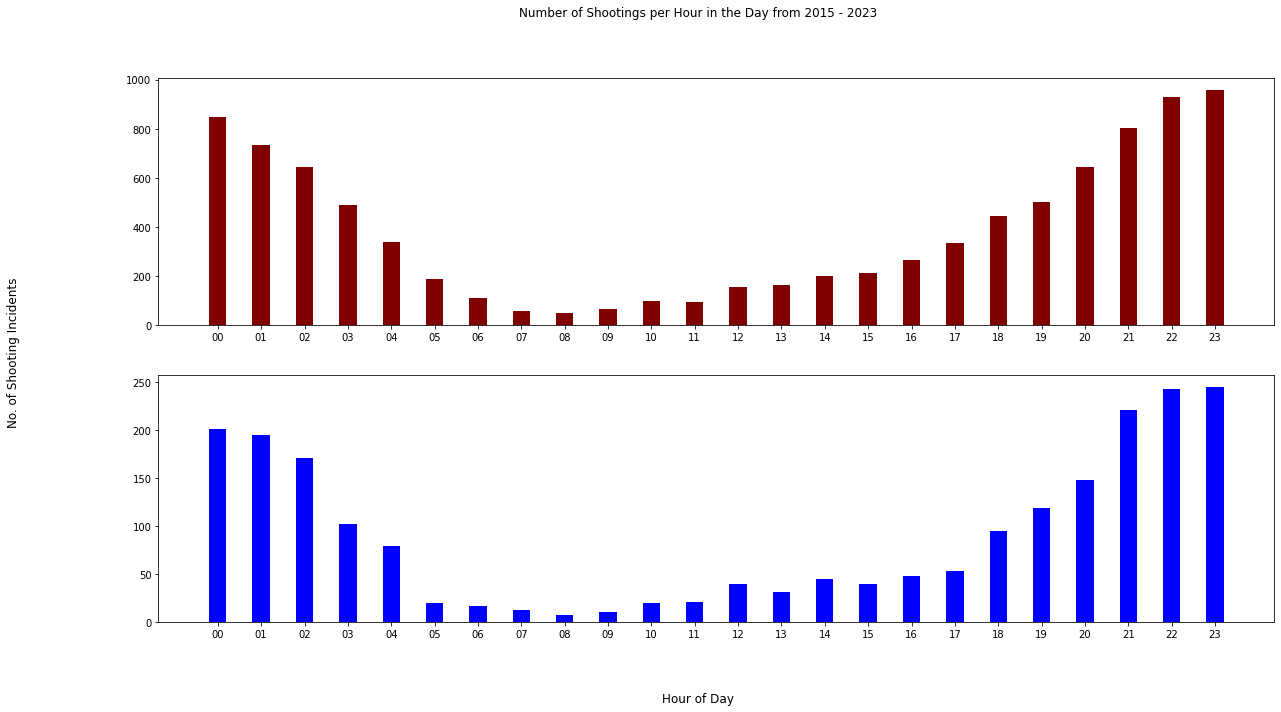

In [ ]:
#load data
shots_fired_URL = "https://data.boston.gov/api/3/action/datastore_search?resource_id=c1e4e6ac-8a84-4b48-8a23-7b2645a32ede&limit=7553"
shootings_URL = "https://data.boston.gov/api/3/action/datastore_search?resource_id=73c7e069-701f-4910-986d-b950f46c91a1&limit=1798"
shot_nv = pd.DataFrame((rq.get(url = shots_fired_URL)).json().get('result').get('records'))
shot_v = pd.DataFrame((rq.get(url = shootings_URL)).json().get('result').get('records'))
print(shot_nv.keys())
print(shot_nv.shape)
print("\n")
print(shot_v.keys())
print(shot_v.shape)

#execute order 66
# only get district column
shot_nv = shot_nv[['district', 'incident_date']]
shot_v = shot_v.rename(columns={'shooting_date': 'incident_date'})
shot_v = shot_v[['district', 'incident_date']]
# get shootings by hour
shot_nv['incident_hour'] = shot_nv['incident_date'].str[11:13]
shot_v['incident_hour'] = shot_v['incident_date'].str[11:13]
# reset stuff to combine datasets
shot_nv.reset_index(drop=True, inplace=True)
shot_v.reset_index(drop=True, inplace=True)
# combine
frames = [shot_nv, shot_v]
result = pd.concat(frames)
# count duplicates to get number of incidents 
result_all = result.pivot_table(index = ['incident_hour'], aggfunc ='size').reset_index()
result_all.rename(columns={0: 'num_inc'}, inplace=True)

#delete districts that arent in d4
district_4 = ['B2', 'B3', 'C11', 'E5']
result_d4 = result[~ result['district'].isin(district_4)]
result_d4 = result_d4.pivot_table(index = ['incident_hour'], aggfunc ='size').reset_index()
result_d4.rename(columns={0: 'num_inc'}, inplace=True)
# loop through hours and get graph

fig, (ax1, ax2) = plt.subplots(2,figsize=(20, 10))
ax1.bar(result_all['incident_hour'], result_all['num_inc'], color ='maroon',
        width = 0.4)

ax2.bar(result_d4['incident_hour'], result_d4['num_inc'], color ='blue',
        width = 0.4)

fig.supxlabel("Hour of Day")
fig.supylabel("No. of Shooting Incidents")
fig.suptitle("Number of Shootings per Hour in the Day from 2015 - 2023")
plt.show()

Summary:

* Overall we can see the data supports the asumption that more gun incidents happen in the night rather than the day
* We can also see a very nice parabolic trend of gun violence incidents which has interesting mathematical properties that can be exploted with further reserarch
* Its also observed that gun violence incidents in council district 4 have the same parabolic trend as the rest of Boston which indicates there is nothing abnormal about gun violence incident times in district 4

### Number of Fatal vs Non-Fatal Shootings per District per Year

In [ ]:
URL = "https://data.boston.gov/datastore/odata3.0/73c7e069-701f-4910-986d-b950f46c91a1?$top=10000&$format=json"

r = rq.get(url = URL)
data = r.json()
data = data.get('value')
df = pd.DataFrame(data)

print(df.keys())

Index(['shooting_type_v2', 'victim_ethnicity_NIBRS', 'district',
       'incident_num', 'victim_race', 'multi_victim', 'victim_gender', '_id',
       'shooting_date'],
      dtype='object')


In [ ]:
fatal = "fatal"
non_fatal = "non-fatal"
districts = ['B2', 'B3', 'C11', 'E5', 'A1', 'A7', 'A15', 'C6', 'D4', 'D14', 'E13', 'E18']
district_4 = ['B2', 'B3', 'C11', 'E5']

def get_year(row):
    return row.split('-')[0]

def get_shooting_type(row):
    if row['index'] % 2 == 0:
        return fatal
    else:
        return non_fatal 

district_index = 0
def get_district(row):
    global district_index
    district = ""
    if district_index == len(districts):
        district_index = 0
        district = districts[district_index]
    else:
        district = districts[district_index]
        if row['index'] % 2 == 1:
            district_index += 1

    return district

def get_data_per_year_district_shooting_type(row):
    if row['shooting_type_v2'] == "Fatal":
        val = list(df3[(df3['year'] == row['year']) 
                       & (df3['district'] == row['district']) 
                       & (df3['shooting_type'] == fatal)]['number_of_shootings'].astype(int))
        
        val[0] += row['number of shootings']
        index = list(df3[(df3['year'] == row['year']) 
                         & (df3['district'] == row['district']) 
                       & (df3['shooting_type'] == fatal)]['index'])[0]
        df3.loc[index,'number_of_shootings'] = val[0]
    else:
        val = list(df3[(df3['year'] == row['year']) 
                       & (df3['district'] == row['district']) 
                       & (df3['shooting_type'] == non_fatal)]['number_of_shootings'].astype(int))
        
        val[0] += row['number of shootings']
        index = list(df3[(df3['year'] == row['year']) 
                         & (df3['district'] == row['district']) 
                       & (df3['shooting_type'] == non_fatal)]['index'])[0]
        df3.loc[index,'number_of_shootings'] = val[0]

df2 = df.copy()
df2['year'] = df2['shooting_date'].apply(get_year)
years = df2['year'].unique()

# added reset index to turn the series back to a dataframe
data_district_per_year = df2.groupby(['year', 'district', 'shooting_type_v2']).size().reset_index()
df2 = pd.DataFrame(data_district_per_year).reset_index()
df2.rename(columns={0: 'number of shootings'}, inplace=True)
years = df2['year'].unique()

df3 = pd.DataFrame(years)
df3.rename(columns={0: 'year'}, inplace=True)
# Repeat the years twice, so have 2 rows with the same year for each district, one for fatal, another for non-fatal
df3 = df3.loc[df3.index.repeat(2 * len(districts))].reset_index(drop=True)
# Add index to the dataset, to be used in assigning the location (District 4 and Rest of Boston)
df3['index'] = df3.index
# Rearrange the order of columns
df3 = df3[['index', 'year']]
df3['district'] = df3.apply(get_district, axis=1)
# Assign fatal or non-fatal to location column
df3['shooting_type'] = df3.apply(get_shooting_type, axis=1)
df3['number_of_shootings'] = 0
df2.apply(get_data_per_year_district_shooting_type, axis=1)
print(district_4)

['B2', 'B3', 'C11', 'E5']


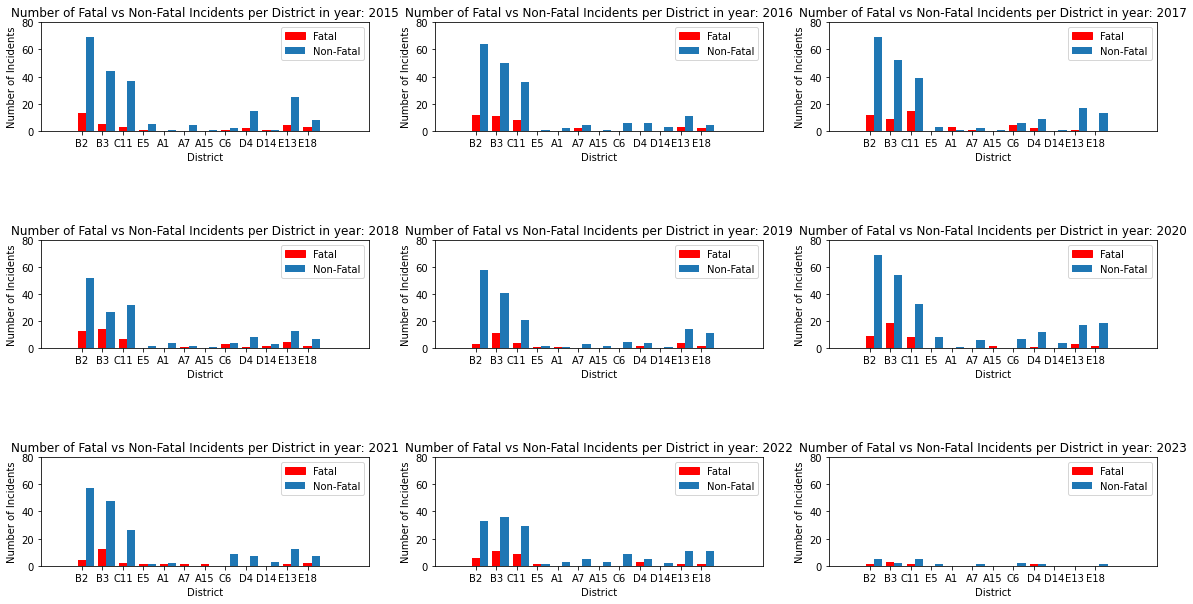

In [ ]:
plt.figure(figsize=(20, 10))
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.subplots_adjust(hspace=1)
width = 0.4
i = 0
for year in years:
    x_axis = np.arange(len(districts))
    data = df3[df3['year'] == year]
    ax = plt.subplot(3, 3, i + 1)
    fatal_bar = ax.bar(x_axis, data[(data['shooting_type'] == fatal)]['number_of_shootings'], width=width, color='red', align='center')
    non_fatal_bar = ax.bar(x_axis + width, data[(data['shooting_type'] == non_fatal)]['number_of_shootings'], width=width, align='center')
    ax.set_xticks(x_axis)
    ax.set_xticklabels(list(districts))
    ax.set_title('Number of Fatal vs Non-Fatal Incidents per District in year: ' + str(year))
    ax.set_xlabel('District')
    ax.set_ylabel('Number of Incidents')
    ax.set_ylim(ymax=80)
    red_patch = mpatches.Patch(color='red', label='Fatal')
    blue_patch = mpatches.Patch(label='Non-Fatal')
    ax.legend(bbox_to_anchor=(1, 1), handles=[red_patch, blue_patch])
    i += 1

plt.show()

The graph above is meant to show a comparison of how fatal vs non-fatal shooting incidents in the various districts have changed over the years, given the y-axis is the same (max. 80). This is easy for the layman to observe the various trends.

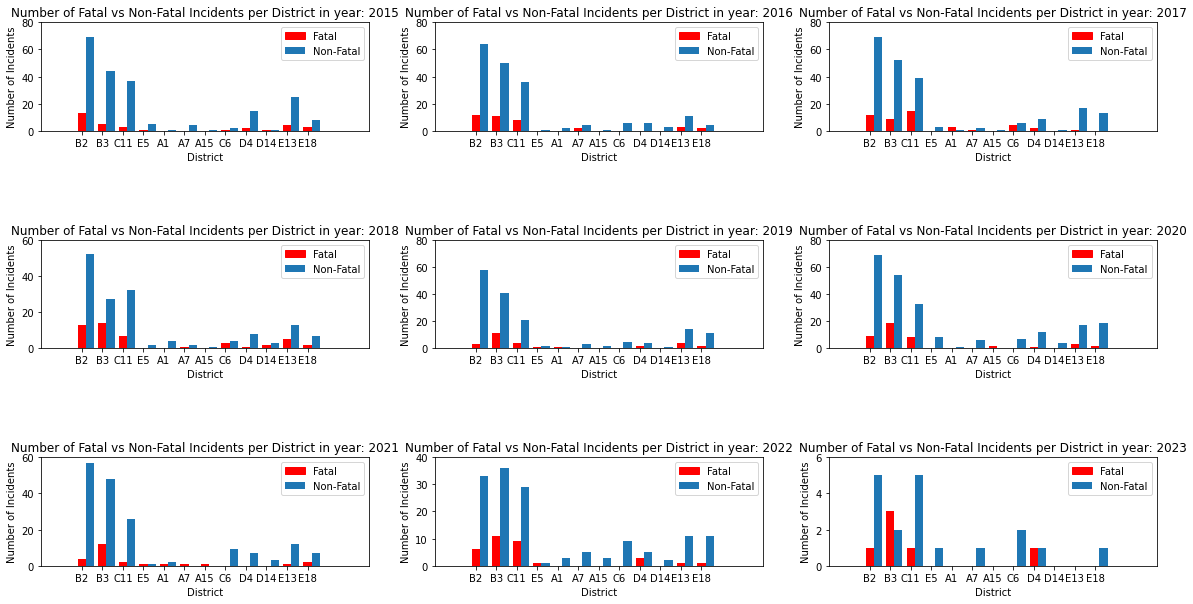

In [ ]:
plt.figure(figsize=(20, 10))
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.subplots_adjust(hspace=1)
width = 0.4
i = 0
for year in years:
    x_axis = np.arange(len(districts))
    data = df3[df3['year'] == year]
    ax = plt.subplot(3, 3, i + 1)
    fatal_bar = ax.bar(x_axis, data[(data['shooting_type'] == fatal)]['number_of_shootings'], width=width, color='red', align='center')
    non_fatal_bar = ax.bar(x_axis + width, data[(data['shooting_type'] == non_fatal)]['number_of_shootings'], width=width, align='center')
    ax.set_xticks(x_axis)
    ax.set_xticklabels(list(districts))
    ax.set_title('Number of Fatal vs Non-Fatal Incidents per District in year: ' + str(year))
    ax.set_xlabel('District')
    ax.set_ylabel('Number of Incidents')
    red_patch = mpatches.Patch(color='red', label='Fatal')
    blue_patch = mpatches.Patch(label='Non-Fatal')
    ax.legend(bbox_to_anchor=(1, 1), handles=[red_patch, blue_patch])
    i += 1

plt.show()

For a clearer analysis, the above chart displays the same data, but in a form that is clearer for each year as it is able to zoom in to those with less than 80 incidents in that year.

Key findings from the graph:
1. Except police district B3 in 2023, the other districts have more non-fatal shooting incidents compared to fatal incidents. This could mean that most shooting incidents were probably not targeted shootings.
2. There are/were some districts with no fatal shootings and even negligible non-fatal shootings e.g. district A15 in 2016, 2019, etc. 
3. Police district B2, which is a part of congressional district D4, has the highest number of non-fatal shooting incidents every year, except in 2022, where B3 had the highest number, and 2023, where it is tied with C11, another police district under congressional district D4.
4. Police district B3, which is a part of congressional district D4, has the highest number of fatal shooting incidents every year from 2018 to 2023. 

### Average number of shootings per day of the week vs district (across the years)

In [ ]:
shots_fired_URL = "https://data.boston.gov/api/3/action/datastore_search?resource_id=c1e4e6ac-8a84-4b48-8a23-7b2645a32ede&limit=7553"
shootings_URL = "https://data.boston.gov/api/3/action/datastore_search?resource_id=73c7e069-701f-4910-986d-b950f46c91a1&limit=10000"
shots_fired = pd.DataFrame((rq.get(url = shots_fired_URL)).json().get('result').get('records'))
shootings = pd.DataFrame((rq.get(url = shootings_URL)).json().get('result').get('records'))

In [ ]:
def get_day_of_week(date):
  date=date.str[:10]
  date_v = date.str.split("-")
  days=[]
  week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
  for date in date_v:
    date_values=[int(x) for x in date]
    days.append(week[dt.date(day=date_values[2], month=date_values[1], year=date_values[0]).weekday()])
  return days

<Figure size 720x432 with 0 Axes>

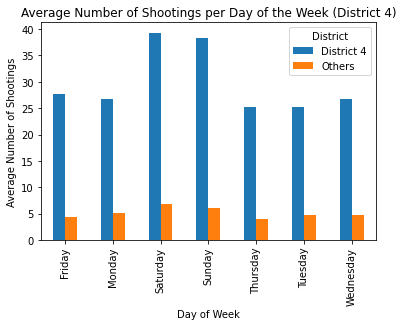

In [ ]:
shots_fired = shots_fired[['district', 'incident_date']]
shootings = shootings.rename(columns={'shooting_date': 'incident_date'})
shootings = shootings[['district', 'incident_date']]

shots_fired.reset_index(drop=True, inplace=True)
shootings.reset_index(drop=True, inplace=True)

frames = [shots_fired, shootings]
result = pd.concat(frames)

result["day_of_week"] = get_day_of_week(result["incident_date"])
result["year"] = result["incident_date"].str[:4]

result = result.pivot_table(index = ['year', 'day_of_week', 'district'], aggfunc ='size').reset_index()
result.rename(columns={0: 'num_inc'}, inplace=True)

district_4 = ['B2', 'B3', 'C11', 'E5']
years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
result_mean = result.groupby(['day_of_week', 'district','year'])['num_inc'].mean().reset_index()

result_mean['group'] = 'Others'
result_mean.loc[result_mean['district'].isin(district_4), 'group'] = 'District 4'
result_pivot = result_mean.pivot_table(index='day_of_week', columns='group', values='num_inc')
plt.figure(figsize=(10, 6))
result_pivot.plot(kind='bar')
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Shootings')
plt.title('Average Number of Shootings per Day of the Week (District 4)')
plt.legend(title='District')

> The first plot is for comparing the Average number of shootings in District 4 vs The other distrcits across 2015-2023 per day of week. 

Key findings from the graph:
- From the first plot we can see 2 key observations:
  - The average number of shootings in District 4 is remarkably higher than all other districts combined
  - We see a higher average of shootings over the weekend(Saturday,Sundays) than in weekdays.

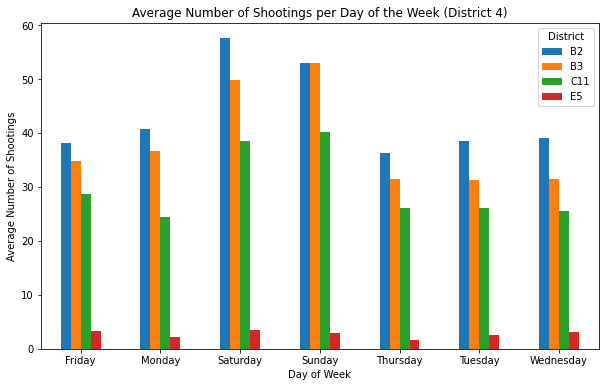

In [ ]:
result_mean_district_4 = result_mean[result_mean['district'].isin(district_4)]
result_pivot = result_mean_district_4.pivot_table(index='day_of_week', columns='district', values='num_inc')
result_pivot.plot(kind='bar', figsize=(10, 6), rot=0)
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Shootings')
plt.title('Average Number of Shootings per Day of the Week (District 4)')
plt.legend(title='District')

> The second plot is for delving deeper into District 4 and analysing the data w.r.t police districts (B2,B3,C11,E5) that constitute District 4.

Key findings form the graph:
- From the second plot we can see 2 key observations:
  - Police District B2 is the most affected out of the 4 police districts constituting District 4.
  - We again see the trend of a higher average of shootings over the weekend(Saturday,Sundays) than in weekdays.

### Shooting Incidents by Victim's Race and Gender



In [ ]:
# Loading the data
shootings_URL = "https://data.boston.gov/api/3/action/datastore_search?resource_id=73c7e069-701f-4910-986d-b950f46c91a1&limit=10000"
shot_v = pd.DataFrame((rq.get(url = shootings_URL)).json().get('result').get('records'))

# Filtering the dataset to get all D4 districts together
selected_districts = ['D4', 'C11', 'B3', 'B2', 'E5']
D4_df = shot_v[shot_v['district'].isin(selected_districts)]

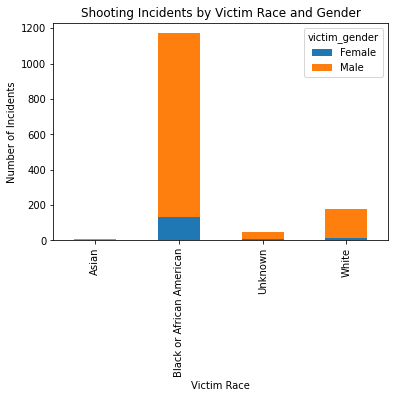

In [ ]:
# Plotting the graph to find any patterns between Victim's gender and race
race_gender_counts = D4_df.groupby(['victim_race', 'victim_gender']).size().unstack()
race_gender_counts.plot(kind='bar', stacked=True)
plt.xlabel('Victim Race')
plt.ylabel('Number of Incidents')
plt.title('Shooting Incidents by Victim Race and Gender')
plt.show()


It is pretty evident from this graph that *Black Men* are targetted the most in these shootings. 
Although, the number of *White Men* is very low compared to *Black Men* but this is also sufficient and we should also try to look into it.

### Multiple Victims vs Single Victims

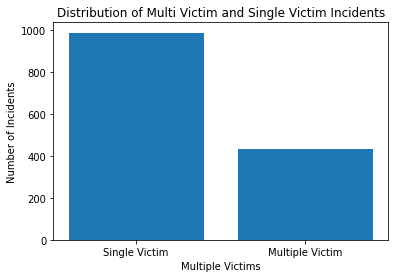

In [ ]:
# Plotting the graph to understand the distribution of multi victim and single victim incidents
multi_victim_counts = D4_df['multi_victim'].value_counts()
plt.bar(['Single Victim', 'Multiple Victim'], multi_victim_counts)
plt.title('Distribution of Multi Victim and Single Victim Incidents')
plt.xlabel('Multiple Victims')
plt.ylabel('Number of Incidents')
plt.show()

This is very interesting, because we can also deduce that as the number of single victims is almost the double of multiple victims, this could be happening because of some targetted issue or clash between the victim and perosn who was guilty.

### Shooting sIncidents on Holidays and Non Holidays

In [ ]:
# Code to add holiday column to our data frame
def get_date(row):
    return row.split(' ')[0]
def check_is_holiday(row):
    if row in holidays:
        return True
    return False
D4_df['shooting_date'] = D4_df['shooting_date'].apply(get_date)
holidays = ['2015-01-01', '2015-01-19', '2015-02-16', '2015-04-20', '2015-05-25', '2015-06-19',
            '2015-07-03', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25',
            '2016-01-01', '2016-01-18', '2016-02-15', '2016-04-18', '2016-05-30', '2016-06-19',
            '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-26',
            '2017-01-02', '2017-01-16', '2017-02-20', '2017-04-17', '2017-05-29', '2017-06-19',
            '2017-07-04', '2017-09-04', '2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25',
            '2018-01-01', '2018-01-15', '2018-02-19', '2018-04-16', '2018-05-28', '2018-06-19',
            '2018-07-04', '2018-09-03', '2018-10-08', '2018-11-12', '2018-11-22', '2018-12-05', '2018-12-25',
            '2019-01-01', '2019-01-21', '2019-02-18', '2019-04-15', '2019-05-27', '2019-06-19',
            '2019-07-04', '2019-09-02', '2019-10-14', '2019-11-11', '2019-11-28', '2019-12-25',
            '2020-01-01', '2020-01-20', '2020-02-17', '2020-03-17', '2020-05-20', '2020-06-19',
            '2020-07-03', '2020-09-07', '2020-10-12', '2020-11-11', '2020-11-26', '2020-12-25',
            '2021-01-01', '2021-01-18', '2021-02-15', '2021-03-17', '2021-04-19', '2021-05-31', '2021-06-19',
            '2021-07-05', '2021-09-06', '2021-10-11', '2021-11-11', '2021-11-25', '2021-12-24',
            '2022-01-17', '2022-02-21', '2022-03-17', '2022-04-18', '2022-05-30', '2022-06-19',
            '2022-07-04', '2022-09-05', '2022-10-10', '2022-11-11', '2022-11-24', '2022-12-26',
            '2023-01-02', '2023-01-16', '2023-02-20', '2023-03-17', '2023-04-17', '2023-05-29', '2023-06-19',
            '2023-07-04', '2023-09-04', '2023-10-09', '2023-11-10', '2023-11-23', '2023-12-25']
D4_df['is_holiday'] = D4_df['shooting_date'].apply(check_is_holiday)
shot_v['is_holiday'] = shot_v['shooting_date'].apply(check_is_holiday)

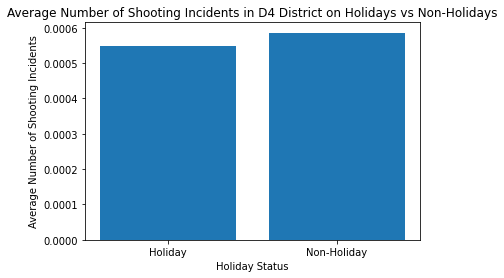

In [ ]:
# Plotting the graph for Average Shootings on Holidayvs non Holidays
avg_shootings_holiday = len(D4_df[D4_df['is_holiday'] == True]['incident_num'].unique())/(len(D4_df) * len(D4_df[D4_df['is_holiday'] == True]))
avg_shootings_non_holiday = len(D4_df[D4_df['is_holiday'] == False]['incident_num'].unique())/(len(D4_df) * len(D4_df[D4_df['is_holiday'] == False]))

averages = [avg_shootings_holiday, avg_shootings_non_holiday] 
labels = ['Holiday', 'Non-Holiday']
plt.bar(labels, averages)
plt.title('Average Number of Shooting Incidents in D4 District on Holidays vs Non-Holidays')
plt.xlabel('Holiday Status')
plt.ylabel('Average Number of Shooting Incidents')
plt.show()

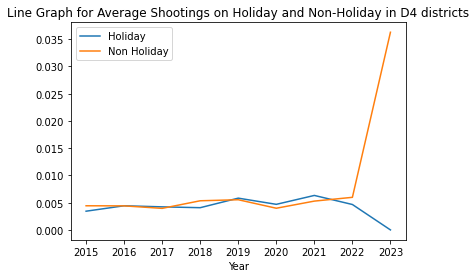

In [ ]:
# A year wise comaparison of shootings on holidays and non holidays
D4_df['shooting_date'] = pd.to_datetime(D4_df['shooting_date'])

D4_df['year'] = D4_df['shooting_date'].dt.year

years = D4_df['year'].unique()

shootings_holiday = []
shootings_non_holiday = []

for year in years:
  D4_year = D4_df[D4_df['year'] == year]
  if len(D4_year[D4_year['is_holiday'] == True]) == 0:
    shootings_holiday.append(len(D4_year[D4_year['is_holiday'] == True]['incident_num'].unique())/(len(D4_year) * 1))
  else:
    shootings_holiday.append(len(D4_year[D4_year['is_holiday'] == True]['incident_num'].unique())/(len(D4_year) * len(D4_year[D4_year['is_holiday'] == True])))
  
  shootings_non_holiday.append(len(D4_year[D4_year['is_holiday'] == False]['incident_num'].unique())/(len(D4_year) * len(D4_year[D4_year['is_holiday'] == False])))
plt.plot(years, shootings_holiday, label='Holiday')
plt.plot(years, shootings_non_holiday, label='Non Holiday')
plt.xlabel('Year')
plt.title('Line Graph for Average Shootings on Holiday and Non-Holiday in D4 districts')
plt.legend()
plt.show()

From the above two graphs, we can see that number of incidents on Holidays and Non-Holidays are almost similar. 